# Airbnb Occupancy Rate - Visualization & Prediction

Airbnb business expands rapidly these days and there should be a great deal of opportunities hidden behind Airbnb data. For both hosts and Airbnb, there might involve a large amount of cost to make improvement and attract more guests' interests. So, it might be valuable to carry out a deep research about what the guests cares most when they are searching for a place to stay. 

With accessibiity to __listings, calendar and review__ datasets, I'd like to dip out some potential opportunities for hosts and product roadmap for Airbnb in US major cities. Considering both hosts and Airbnb aim to converting visitors to guests, I select the __"Occupancy Rate"__ as the target variable in this project and figure out some interesting features about location, price, seasonal, cancellation policy and review.  


__Model:__



__Data Source:__ http://insideairbnb.com/

__Datasets:__
- listings
- calendar
- review

__Timebox:__
- reviews: historical data before 2020-01-08
- calendar: 2019-01-18 to 2020-01-08

__Cities:__
- Boston
- Chicago
- Los Angeles
- New York
- San Francisco
- Seattle




__Interest Findings:__

__For hosts__ in Airbnb, it is always costly to make some change for their properties to improve their occupancy and income. So the findings below might be helpful for them to make decision about their rental operations with less costs.

- There is obvious business season for properties. Hosts could arrange reconstruction or decoration during __February and March__. 

- It is not actionable to change property type but easy to change the room type. There is an obvious difference that the __private room__ is more likely to attract guests compared to entire home/apt and shared room.

- Reversely, __price__ is not the most important driver for occupancy rate. But the occupancy rate distribution performs quite difference in low price range and high price range. It might because the guests care more about other categories if the prices are similar.

- The __cancellation policy__ is the top priority for guest to select a plact to stay. 
So, it is much easier for hosts to change their cancellation policy and price to increase the occupancy rate. 


__For Airbnb:__

For the 6 marjor cities, there are great potentials for cities __LA, SF, Chicago__ with relatively lower occupancy rate. It might be the reason for local transportation, neighborhood, properties avaiable and etc. So, data scientist could go deeper to research about bias in different cities and optimize the recommendation engine to be more specific. 

For each of the cities, in order to be more straigtforward, I build up dashboards to track and research about the occupancy rate distributions. Here is the example for SF https://public.tableau.com/profile/xuan.liu7775#!/vizhome/AirbnbOccupancyRate-SF/DashboardSFOccupancyRate?publish=yes.




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import plotly.offline as py
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn import svm

from string import punctuation

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import ngrams

from itertools import chain
from wordcloud import WordCloud


Bad key "text.kerning_factor" on line 4 in
/Users/liuxuan/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


# Data Preparation

##### Import Data

In [2]:
path  = '/Users/liuxuan/Desktop/未命名檔案夾 3/Xuan Liu Career/Data/Airbnb/'
City = ['SF', 'LA', 'NY', 'ST', 'CG', 'BT']

dfs = []
for col in City:
    df = pd.read_csv(path+col+'/reviews.csv')
    df['city'] = col
    dfs.append(df)
reviews = pd.concat(dfs, ignore_index=True)

dfs = []
for col in City:
    df = pd.read_csv(path+col+'/calendar.csv')
    df['city'] = col
    dfs.append(df)
calendar = pd.concat(dfs, ignore_index=True)

dfs = []
for col in City:
    if col in ['SF', 'ST']:
        df = pd.read_csv(path+col+'/listings.csv', encoding= 'unicode_escape')
    else:
        df = pd.read_csv(path+col+'/listings.csv')
    df['city'] = col
    df = df[['id', 'host_id',  'cancellation_policy', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'zipcode', 'property_type', 'room_type', 'availability_365', 'review_scores_value', 'review_scores_rating', 'city']]
    dfs.append(df)
lists = pd.concat(dfs, ignore_index=True)

/Users/liuxuan/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (43,61,62) have mixed types.Specify dtype option on import or set low_memory=False.

/Users/liuxuan/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (43,61,62,94,95) have mixed types.Specify dtype option on import or set low_memory=False.

/Users/liuxuan/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (61,62,94) have mixed types.Specify dtype option on import or set low_memory=False.



# Occupancy Rate

In [3]:
df_OR = pd.merge(lists, calendar, left_on = 'id', right_on = 'listing_id', how = 'outer')
df_OR = df_OR[['date', 'listing_id', 'host_id', 'cancellation_policy', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'availability_365', 'review_scores_value', 'review_scores_rating', 'city_x', 'available', 'price', 'adjusted_price']].rename(columns = {'city_x':'city'})
df_OR['date'] = pd.to_datetime(df_OR['date']) 
df_OR = df_OR[(df_OR['date'] <= '2020-01-08') & (df_OR['date'] >= '2019-01-18') == True]
df_OR

date  listing_id  host_id cancellation_policy  \
0         2019-01-09         958   1169.0            moderate   
1         2019-01-10         958   1169.0            moderate   
2         2019-01-11         958   1169.0            moderate   
3         2019-01-12         958   1169.0            moderate   
4         2019-01-13         958   1169.0            moderate   
...              ...         ...      ...                 ...   
45223843  2020-01-07    31332147      NaN                 NaN   
45223844  2020-01-08    31332147      NaN                 NaN   
45223845  2020-01-09    31332147      NaN                 NaN   
45223846  2020-01-10    31332147      NaN                 NaN   
45223847  2020-01-11    31332147      NaN                 NaN   

         neighbourhood_group_cleansed  latitude   longitude property_type  \
0                                 NaN  37.76931 -122.433856     Apartment   
1                                 NaN  37.76931 -122.433856     Apartment   
2                                 NaN  37.76931 -122.433856     Apartment   
3                                 NaN  37.76931 -122.433856     Apartment   
4                                 NaN  37.76931 -122.433856     Apartment   
...                               ...       ...         ...           ...   
45223843                          NaN       NaN         NaN           NaN   
45223844                          NaN       NaN         NaN           NaN   
45223845                          NaN       NaN         NaN           NaN   
45223846                          NaN       NaN         NaN           NaN   
45223847                          NaN       NaN         NaN           NaN   

                room_type  availability_365  review_scores_value  \
0         Entire home/apt              75.0                 10.0   
1         Entire home/apt              75.0                 10.0   
2         Entire home/apt              75.0                 10.0   
3         Entire home/apt              75.0                 10.0   
4         Entire home/apt              75.0                 10.0   
...                   ...               ...                  ...   
45223843              NaN               NaN                  NaN   
45223844              NaN               NaN                  NaN   
45223845              NaN               NaN                  NaN   
45223846              NaN               NaN                  NaN   
45223847              NaN               NaN                  NaN   

          review_scores_rating city available    price adjusted_price  
0                         97.0   SF         f  $178.00        $178.00  
1                         97.0   SF         f  $178.00        $178.00  
2                         97.0   SF         f  $150.00        $150.00  
3                         97.0   SF         f  $150.00        $150.00  
4                         97.0   SF         f  $150.00        $150.00  
...                        ...  ...       ...      ...            ...  
45223843                   NaN  NaN         t   $45.00         $45.00  
45223844                   NaN  NaN         t   $45.00         $45.00  
45223845                   NaN  NaN         t   $45.00         $45.00  
45223846                   NaN  NaN         t   $45.00         $45.00  
45223847                   NaN  NaN         f   $45.00         $45.00  

[45223848 rows x 16 columns]

Select the calendar date during 2019-01-18 - 2020-01-08

### Calculate occupancy rate

In [5]:
available_dict = {'t': 1, 'f': 0}
df_OR['available'] = df_OR['available'].map(available_dict)

/Users/liuxuan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Firstly, let's have a glance at the conversion rate throughout the year in the 6 cities: Seattle, San Francisco, Los Angeles, Chicago, Boston and New York.

In [17]:
cmap1 = df_OR[['date', 
               #'neighbourhood_group_cleansed', 
               'city', 
               'latitude','longitude', 
               'available']]
cmap1 = cmap1.dropna()
cmap1['occupied'] = 1-cmap1['available']
cmap1  = cmap1.groupby(['date', 'city']).agg({'occupied':'mean', 'latitude':'mean','longitude':'mean'}).reset_index()
cmap1['date'] = cmap1['date'].astype(str)

cmap1['size'] = cmap1['occupied']/100

fig = px.scatter_mapbox(cmap1, lat="latitude", lon="longitude",
                     color='occupied', size='size',
                     color_continuous_scale='burgyl',
                     animation_frame="date", 
                     title= 'Daily Occupancy Rate by Location Over Time in 2019')
fig.update(layout_coloraxis_showscale=True)
fig.update_layout(mapbox_style="carto-positron", mapbox_zoom=5)
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0})
fig.show()

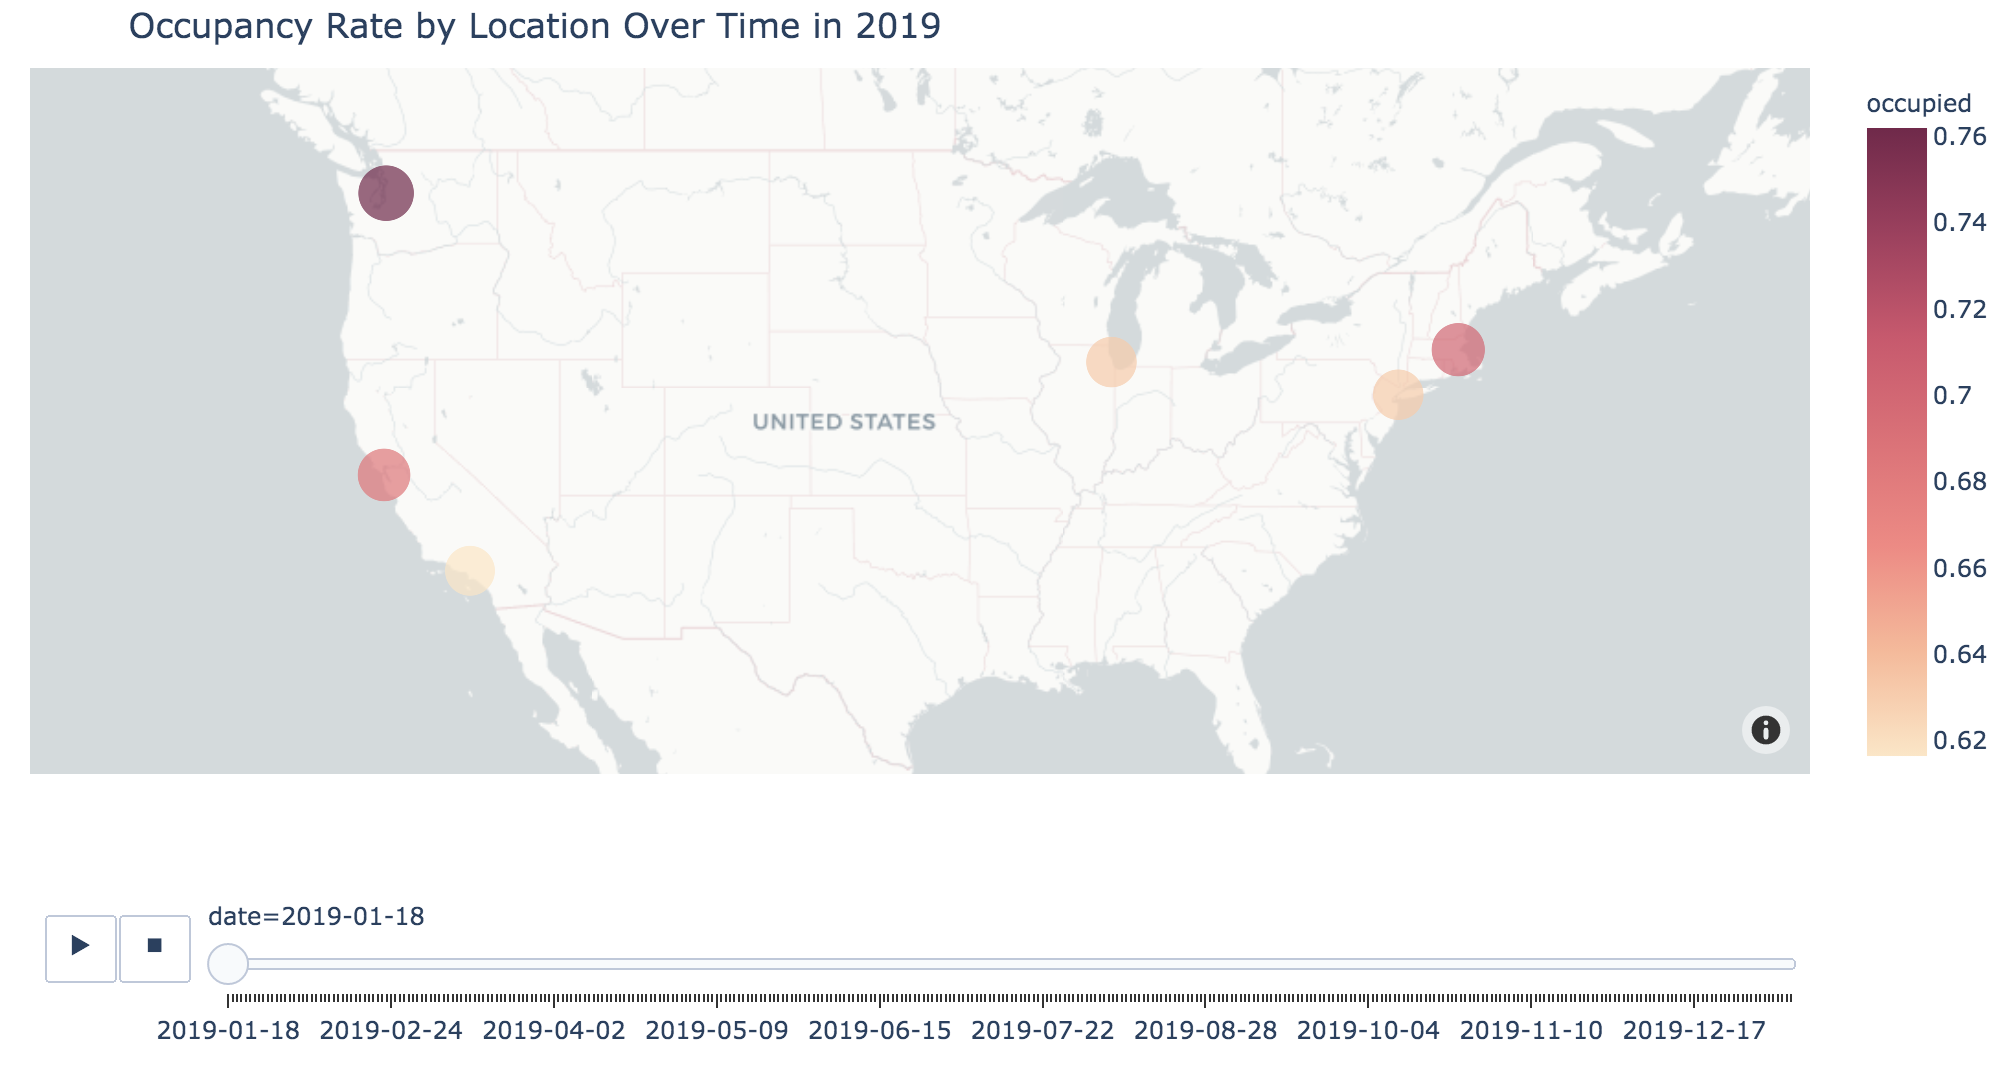

In [127]:
from IPython.display import Image
Image(filename='Occupany Rate Map.png')

There's some interesting things!

Throughout the year, the occupancy rates go up and down simultanously. So, there might by busy seasons.

Roughly, the occupancy rate are in the range [0.4, 0.7]. It is always comparably __higher in Seattle, New York and Boston__ but lower in __Chicago, Los Angeles and San Francisco.__ So, it is valuable to dig deeper in those cities to find some potential opportunities for both hosts and Airbnb.

Then, I am building up __Dashboards__ for each city to track and understand some main drivers for occupancy rate. The link is in the top.

In [20]:
def Occupancy_Rate(data, category):
    return (1-data.groupby(category)['available'].mean()).reset_index().rename(columns = {'available':'occupancy_rate'})

In [21]:
def Occupancy_Rate_Plot(data, category):
    plt.style.use('seaborn-whitegrid')
    sns.lineplot(x = OR[category], y = OR['occupancy_rate'], data = OR)
    plt.title("Occupancy Rate by "+str(category))
    plt.ylabel("Occupancy Rate")
    plt.xlabel(str(category))

In [22]:
def Category_Frequency(data, category):
    return data.groupby([category])['listing_id'].nunique().reset_index().rename(columns = {'listing_id':'count'}).sort_values(by = 'count', ascending = False)

In [23]:
def Category_Frequency_Plot(data, category):
    fig = px.bar(data[[category, 'count']].sort_values('count', ascending=False), 
                 y='count', x=str(category),
                 log_y=True, template='ggplot2', title= 'Frequency of Places Available by '+str(category))
    fig.show()


### Time-Series
##### Occupancy Rate through Timeline

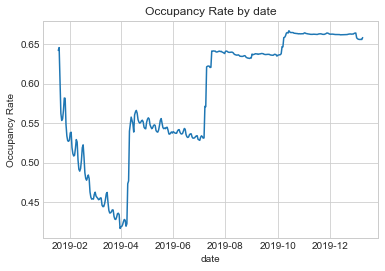

In [13]:
category = 'date'
OR = Occupancy_Rate(df_OR, category)
Occupancy_Rate_Plot(OR, category)

The time-series occupancy rate highly correlated to holiday seasons. It is a sharp drop for occupancy in Q1 but increased gradient in Q2 to Q4. The occupancy remains higher in the Q4.

##### By room_type

Text(0.5,0,'date')

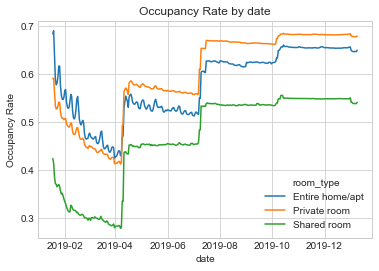

In [65]:
category = ['date', 'room_type']
plt.style.use('seaborn-whitegrid')
sns.lineplot(x = OR['date'], y = OR['occupancy_rate'], data = OR, hue = OR['room_type'])
plt.title("Occupancy Rate by "+str('date'))
plt.ylabel("Occupancy Rate")
plt.xlabel(str('date'))

In Q2 - Q4, there shows an obvious difference for occupancy by room types. The private room should be more likely to attract guests. So, it is actionable for host to have a slight change for the room type. e.g. change the shared room to private room.

Text(0.5,0,'date')

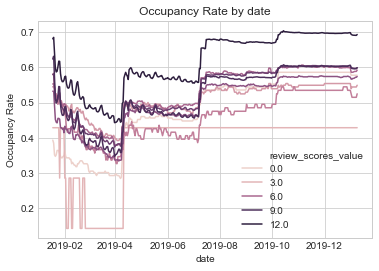

In [67]:
category = ['date', 'review_scores_value']
OR = Occupancy_Rate(df_OR, category)
plt.style.use('seaborn-whitegrid')
sns.lineplot(x = OR['date'], y = OR['occupancy_rate'], data = OR, hue = OR['review_scores_value'])
plt.title("Occupancy Rate by "+str('date'))
plt.ylabel("Occupancy Rate")
plt.xlabel(str('date'))

Text(0.5,0,'date')

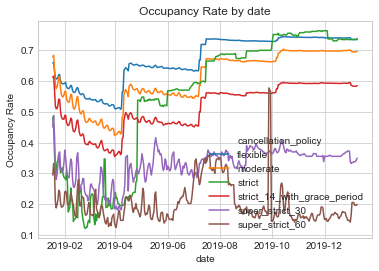

In [68]:
category = ['date', 'cancellation_policy']
OR = Occupancy_Rate(df_OR, category)
plt.style.use('seaborn-whitegrid')
sns.lineplot(x = OR['date'], y = OR['occupancy_rate'], data = OR, hue = OR['cancellation_policy'])
plt.title("Occupancy Rate by "+str('date'))
plt.ylabel("Occupancy Rate")
plt.xlabel(str('date'))

Text(0.5,0,'date')

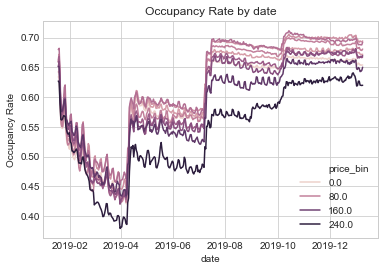

In [70]:
category = ['date', 'price_bin']
OR = Occupancy_Rate(df_OR, category)
plt.style.use('seaborn-whitegrid')
sns.lineplot(x = OR['date'], y = OR['occupancy_rate'], data = OR, hue = OR['price_bin'])
plt.title("Occupancy Rate by "+str('date'))
plt.ylabel("Occupancy Rate")
plt.xlabel(str('date'))

The price range of [50, 160] is more acceptable. Also, Airbnb property should be very price insensitive. So, I'd research deeper for the price category.

##### Occupancy Rate by Price Bins

__'price'__ are splitted into 10 bins by quantiles of 10% increment and each __price_bin__ is label by the lower boundary of price in this bin.

In [15]:
# Splitting price into 10 bins by quantiles.
df_OR['price'] = df_OR['price'].replace('[\$,]', '', regex = True).astype(float)
bins=df_OR['price'].quantile(np.arange(0,1,1/10))
df_OR['price_bin'] = pd.cut(df_OR['price'], bins=bins, labels = np.array(bins[np.arange(0,0.9,1/10)]), include_lowest = True).astype(float)

/Users/liuxuan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/liuxuan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



price_bin  occupancy_rate
0        0.0        0.585478
1       50.0        0.605466
2       65.0        0.619627
3       80.0        0.606881
4       99.0        0.626570
5      118.0        0.598177
6      140.0        0.596605
7      173.0        0.586525
8      216.0        0.542113

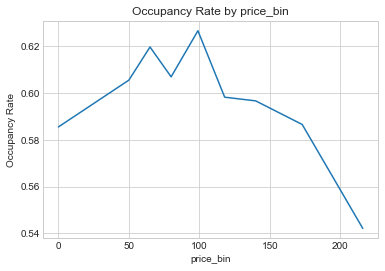

In [39]:
category = 'price_bin'
OR = Occupancy_Rate(df_OR, category)
Occupancy_Rate_Plot(df_OR, category)
OR

-- Not surprisingly! Price have very obvious impact on the occupancy rate. It is very interesting that the properties with price in range [$50, $150] achieves higher occupancy. In the following part, I will develop tree-based model to learn more about splitting point of prices. 

In [52]:
data = Category_Frequency(df_OR, category)
Category_Frequency_Plot(data, category)

Text(0.5,0,'price_bin')

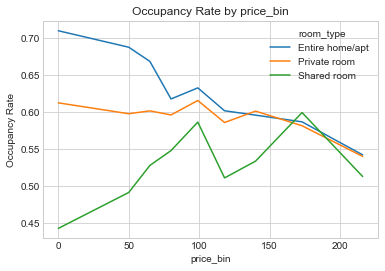

In [27]:
category = ['price_bin', 'room_type']
OR = Occupancy_Rate(df_OR, category)
plt.style.use('seaborn-whitegrid')
sns.lineplot(x = OR['price_bin'], y = OR['occupancy_rate'], data = OR, hue = OR['room_type'])
plt.title("Occupancy Rate by "+str('price_bin'))
plt.ylabel("Occupancy Rate")
plt.xlabel(str('price_bin'))

It is a reverse finding that for lower price property(price < $150) the 'Entire home/apt' is more popular for guests. But higher price property, the 'Shared room' becomes more marketable. It might because of the higher price 'Shared room' provide property of higher quality while guests are more willing to have an 'Entire home/apt' if price is in their budget.

Text(0.5,0,'price_bin')

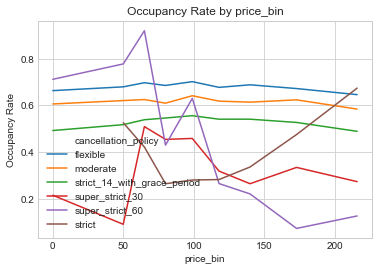

In [29]:
category = ['price_bin', 'cancellation_policy']
OR = Occupancy_Rate(df_OR, category)
plt.style.use('seaborn-whitegrid')
sns.lineplot(x = OR['price_bin'], y = OR['occupancy_rate'], data = OR, hue = OR['cancellation_policy'])
plt.title("Occupancy Rate by "+str('price_bin'))
plt.ylabel("Occupancy Rate")
plt.xlabel(str('price_bin'))

For cancellation policy, __mild policy properties__ and __strict policy properties__ drives quite different occupancy rate distributions.

The mild policy property such as 'flexible', 'moderate' and'strict_14_with_grace_period' always drive the stable occupancy rate and the more flexible properties are more welcomed for guests.

For strict policy, the occupancy distribution varies by price bins. For one thing, the strict policy properties are fewer, so there might be bias. For another thing, the strict policy property might be highly related to other fators. For instance, the property in popular neighborhood might requires strict policy but are still very welcomed.

##### Occupancy Rate by Cancellation Policy

cancellation_policy  occupancy_rate
0                     flexible        0.671298
1                     moderate        0.609310
2                       strict        0.546945
3  strict_14_with_grace_period        0.514181
4              super_strict_30        0.329252
5              super_strict_60        0.202117

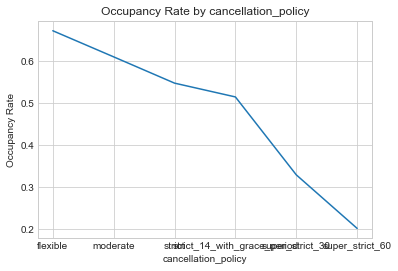

In [36]:
category = 'cancellation_policy'
OR = Occupancy_Rate(df_OR, category)
Occupancy_Rate_Plot(df_OR, category)
OR

Very obviously. The cancellation policy makes strong impact on guests choice.

In [31]:
category = 'cancellation_policy'
data = Category_Frequency(df_OR, category)
Category_Frequency_Plot(data, category)

The fewer properties with strict policy are available -- there might be great bias for guests selection.

##### Occupancy Rate by Review Scores

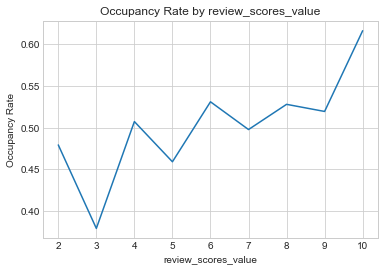

In [37]:
category = 'review_scores_value'
OR = Occupancy_Rate(df_OR, category)
Occupancy_Rate_Plot(df_OR, category)

Roughly, higher review score attracts more customer to stay.

In [38]:
data = Category_Frequency(df_OR, category)
Category_Frequency_Plot(data, category)

__review_scores_value__ is the average score for an Airbnb property rated by guests. There a few __low__ (2 or 3) score properties, so the occupancy may not be representative. The score might be rated by certain extreme experience.

##### Occupancy Rate by Property Type

property_type  occupancy_rate
38               Timeshare        0.974719
34                   Plane        0.955056
13                    Cave        0.666667
27                     Hut        0.637640
1                Apartment        0.631567
11  Casa particular (Cuba)        0.628411
37                    Tent        0.587511
33                   Other        0.581474
30                    Loft        0.580248
35                  Resort        0.571084
7                      Bus        0.570225
6                 Bungalow        0.567996
15             Condominium        0.566547
41               Townhouse        0.562806
14                  Chalet        0.559145
26               Houseboat        0.554693
24                   Hotel        0.552061
21             Guest suite        0.543656
16                 Cottage        0.526610
25                   House        0.507765
8                    Cabin        0.501990
31          Minsu (Taiwan)        0.500000
22              Guesthouse        0.496434
44                    Yurt        0.488764
39              Tiny house        0.472200
4                     Boat        0.465559
5           Boutique hotel        0.460960
12                  Castle        0.457865
9                Camper/RV        0.457188
32            Nature lodge        0.457163
28                  In-law        0.452247
2                     Barn        0.449438
0               Aparthotel        0.448045
20               Farm stay        0.423432
40                    Tipi        0.406367
3        Bed and breakfast        0.404388
36      Serviced apartment        0.403526
43                   Villa        0.357639
19             Earth house        0.305868
23                  Hostel        0.303933
42               Treehouse        0.272673
10                Campsite        0.184992
17              Dome house        0.146536
18                    Dorm        0.012640
29                  Island        0.000000

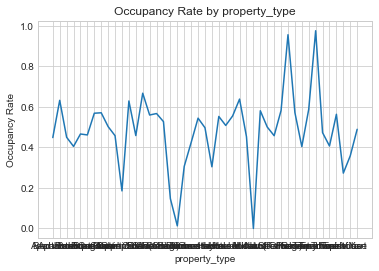

In [39]:
category = 'property_type'
OR = Occupancy_Rate(df_OR, category)
Occupancy_Rate_Plot(df_OR, category)
#OR.sort_values(by = 'occupancy_rate', ascending = False)

For property type category, it is not a actionable factor for hosts. So, we have a glance first. The top occupancy types such as Timeshare, Plane, Hut and Cave are very fanscinating and exclusive chioce.  

We'd better go deep with more marketable property types such as apartment, house, townhouse and etc.

In [40]:
category = 'property_type'
data = Category_Frequency(df_OR, category)
Category_Frequency_Plot(data, category)

##### Occupancy Rate by Room Type

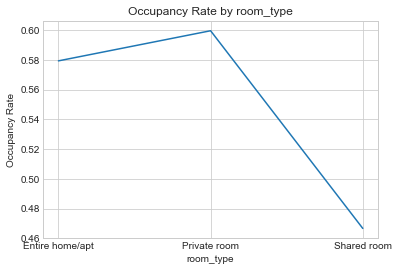

In [41]:
category = 'room_type'
OR = Occupancy_Rate(df_OR, category)
Occupancy_Rate_Plot(df_OR, category)

Makes sense -- the private room is the most popular choive for guests.

##### Occupancy Rate by City

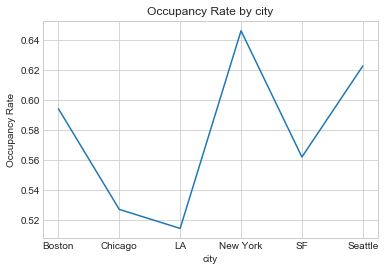

In [42]:
category = 'city'
OR = Occupancy_Rate(df_OR, category)
Occupancy_Rate_Plot(df_OR, category)

# Gaussian Classifier Prediction

There are some factors which have obvious impact for guests' choice. In the following, we'd like to train the models to figure out the top important factors and how the factors impact on the occupancy rate.

Firstly, to set up binary classification of __Occupancy Rate__, the distribution of property's occupancy rate should be calculated out. 

##### Occupancy Rate Distribution

In [35]:
OR = Occupancy_Rate(df_OR, 'listing_id')
df_OR = OR.merge(df_OR, how = 'left', on = 'listing_id')


In [36]:
df_OR

listing_id  occupancy_rate       date     host_id  \
0                109        0.244382 2019-01-18       521.0   
1                109        0.244382 2019-01-19       521.0   
2                109        0.244382 2019-01-20       521.0   
3                109        0.244382 2019-01-21       521.0   
4                109        0.244382 2019-01-22       521.0   
...              ...             ...        ...         ...   
44108395    31642679        0.882022 2020-01-04  57375926.0   
44108396    31642679        0.882022 2020-01-05  57375926.0   
44108397    31642679        0.882022 2020-01-06  57375926.0   
44108398    31642679        0.882022 2020-01-07  57375926.0   
44108399    31642679        0.882022 2020-01-08  57375926.0   

                  cancellation_policy neighbourhood_group_cleansed   latitude  \
0         strict_14_with_grace_period                 Other Cities  33.982095   
1         strict_14_with_grace_period                 Other Cities  33.982095   
2         strict_14_with_grace_period                 Other Cities  33.982095   
3         strict_14_with_grace_period                 Other Cities  33.982095   
4         strict_14_with_grace_period                 Other Cities  33.982095   
...                               ...                          ...        ...   
44108395                     moderate                          NaN  41.944318   
44108396                     moderate                          NaN  41.944318   
44108397                     moderate                          NaN  41.944318   
44108398                     moderate                          NaN  41.944318   
44108399                     moderate                          NaN  41.944318   

           longitude property_type        room_type  availability_365  \
0        -118.384935   Condominium  Entire home/apt             272.0   
1        -118.384935   Condominium  Entire home/apt             272.0   
2        -118.384935   Condominium  Entire home/apt             272.0   
3        -118.384935   Condominium  Entire home/apt             272.0   
4        -118.384935   Condominium  Entire home/apt             272.0   
...              ...           ...              ...               ...   
44108395  -87.648533     Apartment     Private room              43.0   
44108396  -87.648533     Apartment     Private room              43.0   
44108397  -87.648533     Apartment     Private room              43.0   
44108398  -87.648533     Apartment     Private room              43.0   
44108399  -87.648533     Apartment     Private room              43.0   

          review_scores_value  review_scores_rating city  available  price  \
0                         8.0                  80.0   LA          0  118.0   
1                         8.0                  80.0   LA          0  118.0   
2                         8.0                  80.0   LA          0  118.0   
3                         8.0                  80.0   LA          0  118.0   
4                         8.0                  80.0   LA          0  118.0   
...                       ...                   ...  ...        ...    ...   
44108395                  NaN                   NaN   CG          0   50.0   
44108396                  NaN                   NaN   CG          0   50.0   
44108397                  NaN                   NaN   CG          0   50.0   
44108398                  NaN                   NaN   CG          0   50.0   
44108399                  NaN                   NaN   CG          0   50.0   

         adjusted_price  price_bin  
0               $118.00       99.0  
1               $118.00       99.0  
2               $118.00       99.0  
3               $118.00       99.0  
4               $118.00       99.0  
...                 ...        ...  
44108395         $50.00        0.0  
44108396         $50.00        0.0  
44108397         $50.00        0.0  
44108398         $50.00        0.0  
44108399         $50.00        0.0  

[44108400 rows x 18 c

In [37]:
df_OR = df_OR.dropna(subset = ['occupancy_rate'], axis = 0)

In [38]:
bins=df_OR['occupancy_rate'].quantile(np.arange(0,1,1/5))
df_OR['occupancy_rate_bin'] = pd.cut(df_OR['occupancy_rate'], bins = bins, labels = np.array(bins[np.arange(0.2,1,1/5)]), include_lowest = True).astype(float)
bins

0.0    0.000000
0.2    0.081461
0.4    0.519663
0.6    0.794944
0.8    1.000000
Name: occupancy_rate, dtype: float64

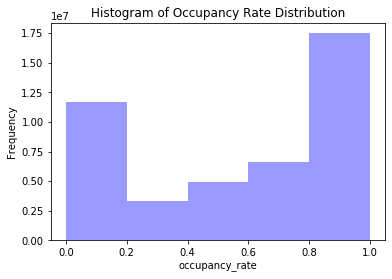

In [41]:
category = 'occupancy_rate'
sns.distplot(list(df_OR[category].values), bins=5,kde=False, color = 'blue')
plt.title('Histogram of Occupancy Rate Distribution')
plt.xlabel(str(category))
plt.ylabel('Frequency')
plt.show()

##### Binary Classification

Splitting the occupancy rate into binary classification:
- occupancy rate in [0, 0.52]: 0
- occupancy rate in [0.79, 1.00]: 1

In [64]:
neutral = df_OR['occupancy_rate_bin'].unique()[1]
OR_dict = {bins[0] : 0, bins[0.2] : 0, bins[0.4] : 0, bins[0.8] : 1}
df_tree = df_OR[df_OR['occupancy_rate_bin'] != neutral] 
#df_OR['occupancy_rate_binary'] = df_OR[df_OR['occupancy_rate_bin']>=0.79]
#df_OR[df_OR['occupancy_rate_bin']<=0.52]

#bins=df_OR['occupancy_rate'].quantile(np.arange(0,1,1/5))

#df_OR['occupancy_rate_bin'].unique()[2]

In [65]:
df_tree = df_tree.dropna()


In [66]:
df_tree.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21152378 entries, 0 to 44016551
Data columns (total 19 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   listing_id                    int64         
 1   occupancy_rate                float64       
 2   date                          datetime64[ns]
 3   host_id                       float64       
 4   cancellation_policy           object        
 5   neighbourhood_group_cleansed  object        
 6   latitude                      float64       
 7   longitude                     float64       
 8   property_type                 object        
 9   room_type                     object        
 10  availability_365              float64       
 11  review_scores_value           float64       
 12  review_scores_rating          float64       
 13  city                          object        
 14  available                     int64         
 15  price                         

In [44]:
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn import tree
from sklearn.externals.six import StringIO 
from IPython.display import Image 
from pydot import graph_from_dot_data
from sklearn.tree import export_graphviz
from sklearn.preprocessing import LabelEncoder

/Users/liuxuan/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



In [67]:
le = LabelEncoder()
for col in ['cancellation_policy', 'property_type', 'room_type','city','neighbourhood_group_cleansed']:
    le.fit(df_tree[col].astype(str))
    df_tree[col] = le.transform(df_tree[col].astype(str))

In [68]:
features = ['cancellation_policy', 'property_type', 'room_type', 'review_scores_value', 'city','neighbourhood_group_cleansed', 'price_bin']
df_tree = df_tree[['occupancy_rate_bin', 'cancellation_policy', 'property_type', 'room_type', 'review_scores_value', 'city','neighbourhood_group_cleansed', 'price_bin']
].drop_duplicates()
X = df_tree[features]
y = df_tree['occupancy_rate_bin'].map(OR_dict)

In [82]:
#dt = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 3)
dt = GradientBoostingRegressor(max_depth = 3)
dt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Then, I am going to check the importance features.

In [83]:
# variable importance
feature_imp = pd.Series(dt.feature_importances_, index = X.columns).sort_values(ascending = False)
feature_imp

property_type                   0.273179
cancellation_policy             0.193483
city                            0.165826
neighbourhood_group_cleansed    0.140968
review_scores_value             0.098344
price_bin                       0.072946
room_type                       0.055254
dtype: float64

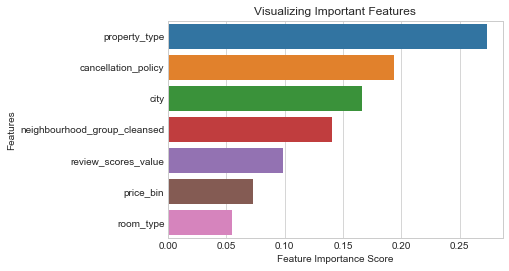

In [84]:
sns.barplot(x = feature_imp, y = feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

Surprisingly -- the price is not the priority and even not a main driver. 

And for 'city' and 'property type', they are not actionable for hosts. But Airbnb might consider about the __recommendation algorithms__ for properties with these features in the webpage to help increase higher conversions.

As for this situation, I am going check about the 'cancellation_policy', 'room_type', 'review_scores_value' and 'price'.

The __property type__ and __city__ are of high importance but not 'actionable' for guest. So, I am going check about the 'cancellation_policy', 'room_type', 'review_scores_value' and 'price'.

In [85]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

features1 = ['cancellation_policy', 'room_type', 'review_scores_value', 'price_bin']
X1 = df_tree[features1]
y1 = df_tree['occupancy_rate_bin'].map(OR_dict)
#dt1 = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 2)
dt1 = GradientBoostingRegressor(max_depth = 2)
dt1.fit(X1, y1)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [86]:
# variable importance
feature_imp1 = pd.Series(dt1.feature_importances_, index = X1.columns).sort_values(ascending = False)
feature_imp1

cancellation_policy    0.445807
room_type              0.225901
review_scores_value    0.170461
price_bin              0.157832
dtype: float64

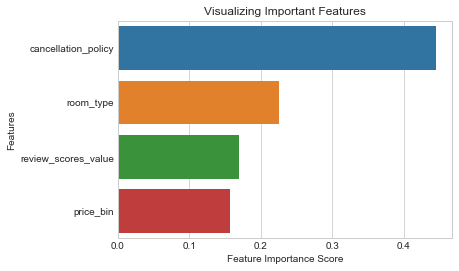

In [87]:
sns.barplot(x = feature_imp1, y = feature_imp1.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

Text(0.5,0.98,'Partial Dependence of Occupancy Rate, with Gradient Boosting')

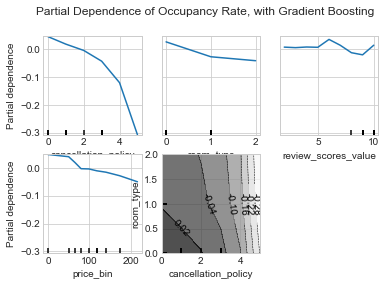

In [95]:
from sklearn.ensemble import GradientBoostingRegressor
dt1 = GradientBoostingRegressor(n_estimators = 100, max_depth = 2)
dt1.fit(X1, y1)
plot_partial_dependence(dt1, X=X1, features = [0, 1, 2, 3, (0,1)], feature_names = X1.columns, n_jobs=2)
fig = plt.gcf()
fig.suptitle('Partial Dependence of Occupancy Rate, with Gradient Boosting')
#fig.subplots_adjust(wspace=0.4, hspace=0.3)


- cancellation policy strongly drives occupancy rate. It is obviously that the milder policy is more acceptable fore guests.

# Decision Tree

Visually, the decision tree shows the splitting point.

In [98]:
dt2 = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 3)
dt2.fit(X1, y1)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

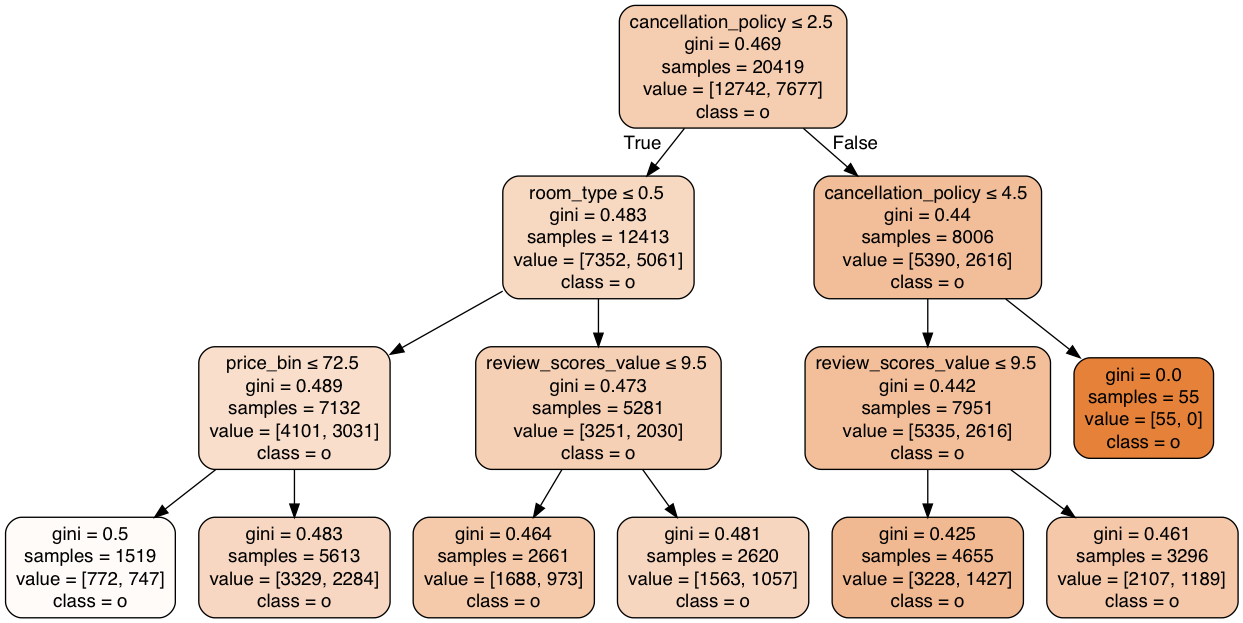

In [99]:
import sklearn.tree as tree
import pydotplus
from sklearn.externals.six import StringIO 
from IPython.display import Image
dot_data = StringIO()
tree.export_graphviz(dt2, 
 out_file=dot_data, 
 class_names='occupancy_rate_bin', # the target names.
 feature_names=features1, # the feature names.
 filled=True, # Whether to fill in the boxes with colours.
 rounded=True, # Whether to round the corners of the boxes.
 special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())